# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Инструкция по выполнению проекта**

- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [1]:
#Импорт необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Может это и не обязательно, но мне гораздо удобнее работать с данными, которые я хотя бы представляю, как выглядят.

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_datagen = datagen.flow_from_dataframe(
    dataframe=df, 
    directory='/datasets/faces/final_files/', 
    x_col='file_name',
    y_col='real_age',
    target_size = (224,224), 
    batch_size=32, 
    class_mode='raw', 
    seed=12345)

Found 7591 validated image filenames.


In [6]:
display(df.describe())
df['real_age'].median()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


29.0

Мне кажется, датасет маленький. Большинство людей довольно молодые, медиана - 29 лет. Наверное это и к лучшему, так как одна из задач - отделить совершеннолетних от несовершеннолетних. А для рекомендательной системы не так важно четко угадать возраст покупателя 70-100 лет, так как в этом возрасте у людей чаще всего одинаковые возрастные нужды. Очень интересно посмотреть на столетнего покупателя из датасета :))

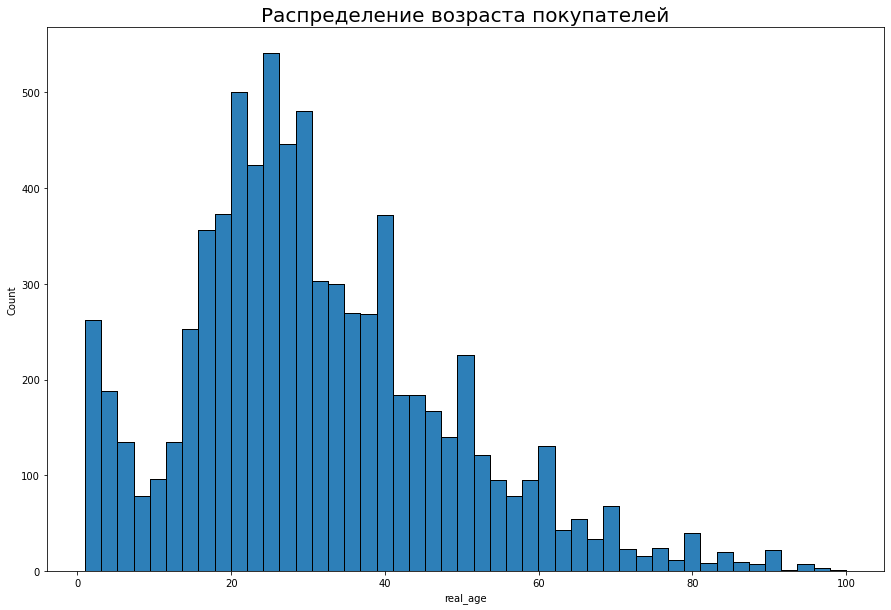

In [7]:
plt.rcParams['figure.figsize']=15,10
sns.histplot(df["real_age"])
sns.histplot(df["real_age"]).set_title('Распределение возраста покупателей', fontdict={'fontsize':20});

**Дорогой ревьюер,** я перепробовала несколько вариантов как дать название графику. Подскажи, как это сделать, чтобы работало, а не как у меня. (plt.title не работает)

Имеется всплеск детей до 5 лет. Это логично, так как таких детей ещё нельзя оставлять дома одних даже на 5 минут выйти в магазин. Так же есть локальные всплески на 40, 50, 60, 70 и 80. Думаю, это связанно с округлением. Как собирались эти данные? Возможно покупатели округляли свой возраст.

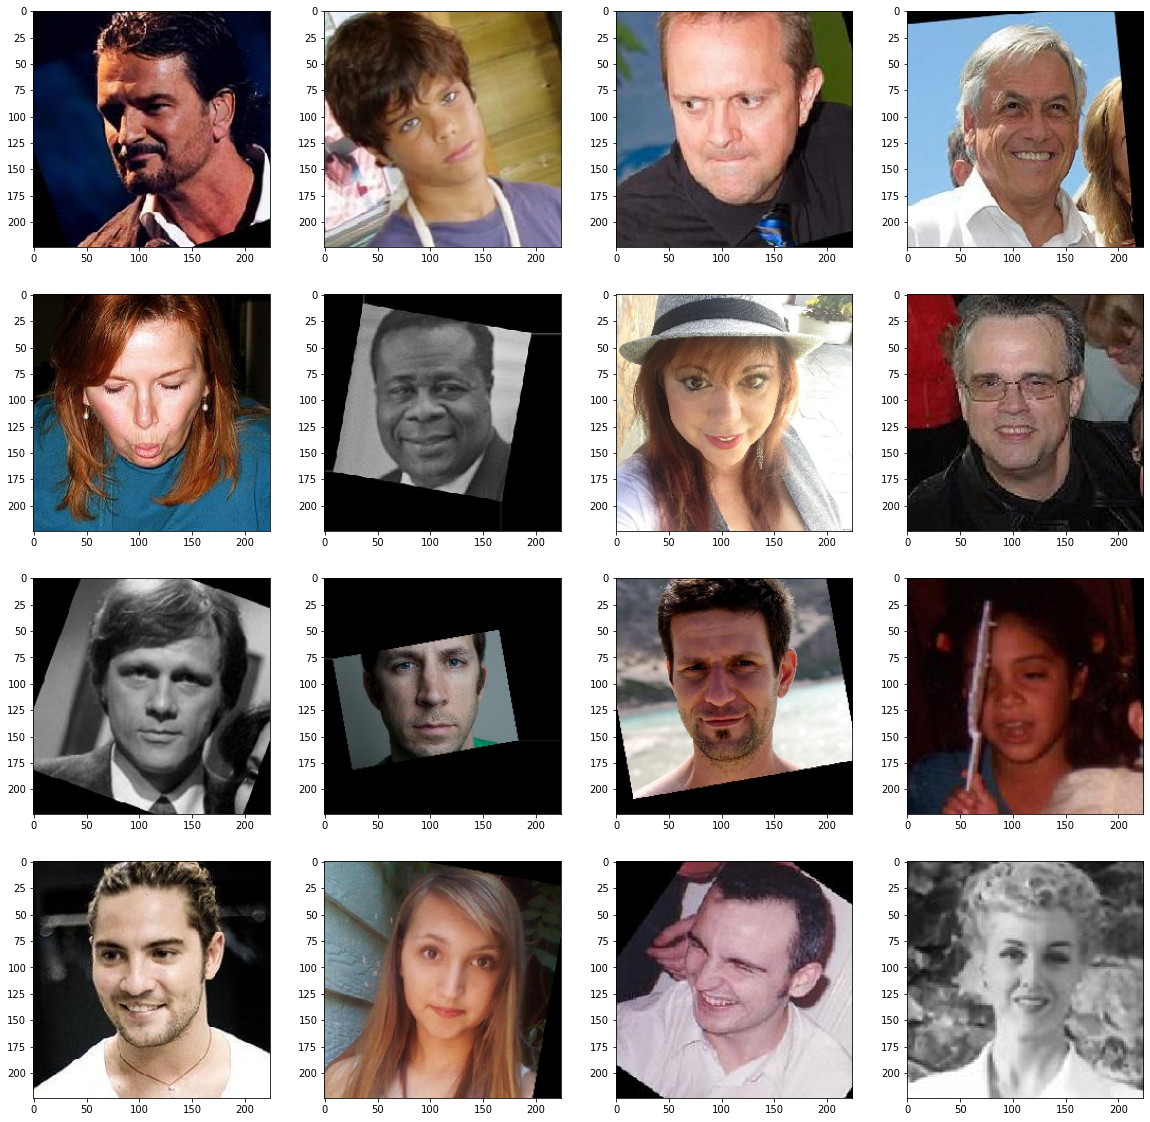

In [9]:
features, target = next(train_datagen)

figure = plt.figure(figsize=(20,20))
for i in range(16):
    array = np.array(features[i])
    figure.add_subplot(4, 4, i+1)
    plt.imshow(array)

Фотографии очень разные. Цветные и черно-белые, ровные и с полями, в анфас и в профиль. Удивительно, неужели модель обучится на таких разных фотографиях? Посмотрим на 100летнего дедулю. Почему-то мне кажется,что это именно дедуля.

In [9]:
df.loc[df["real_age"]==100]

,file_name,real_age
2661,002661.jpg,100


In [10]:
grandpa = Image.open('/datasets/faces/final_files/002661.jpg')

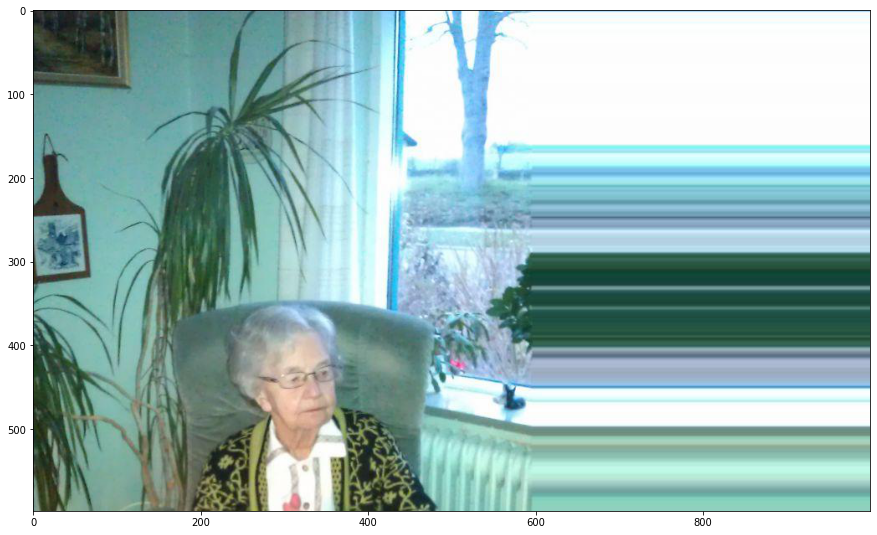

In [11]:
grandpa_array = np.array(grandpa)

plt.imshow(grandpa_array)

О нет! Я не угадала! Это бабуля! Это логично, женщины живут дольше мужчин, но мне все равно казалось, что это делуля. Исправим переменные.

In [12]:
grandma = grandpa
grandma_array = grandpa_array

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Train for 356 steps, validate for 119 steps
Epoch 1/30
2022-07-05 22:31:26.355366: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-05 22:31:28.533625: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 72s - loss: 201.2694 - mae: 10.3512 - val_loss: 668.8741 - val_mae: 20.8620
Epoch 2/30
356/356 - 39s - loss: 83.2304 - mae: 6.8954 - val_loss: 148.3612 - val_mae: 8.9453
Epoch 3/30
356/356 - 38s - loss: 56.1568 - mae: 5.7640 - val_loss: 135.7294 - val_mae: 9.3775
Epoch 4/30
356/356 - 38s - loss: 43.8562 - mae: 5.0820 - val_loss: 78.8091 - val_mae: 6.7870
Epoch 5/30
356/356 - 38s - loss: 33.2039 - mae: 4.4135 - val_loss: 74.1215 - val_mae: 6.4252
Epoch 6/30
356/356 - 38s - loss: 25.2971 - mae: 3.8514 - val_loss: 74.6245 - val_mae: 6.4598
Epoch 7/30
356/356 - 38s - loss: 20.0569 - mae: 3.4130 - val_loss: 71.0096 - val_mae: 6.1838
Epoch 8/30
356/356 - 38s - loss: 15.9216 - mae: 3.0291 - val_loss: 89.5628 - val_mae: 7.2176
Epoch 9/30
356/356 - 38s - loss: 14.4736 - mae: 2.9134 - val_loss: 66.8730 - val_mae: 6.0519
Epoch 10/30
356/356 - 38s - loss: 12.4472 - mae: 2.6713 - val_loss: 66.4312 - val_mae: 6.0414
Epoch 11/30
356/356 - 38s - loss: 12.4156 - mae: 2.7009 - val_loss: 68.8386 - val_mae: 6.2889
Epoch 12/30
356/356 - 38s - loss: 12.9552 - mae: 2.7155 - val_loss: 68.8280 - val_mae: 6.1259
Epoch 13/30
356/356 - 38s - loss: 11.4311 - mae: 2.5661 - val_loss: 65.9137 - val_mae: 6.1075
Epoch 14/30
356/356 - 38s - loss: 11.1683 - mae: 2.5438 - val_loss: 64.0292 - val_mae: 5.8890
Epoch 15/30
356/356 - 38s - loss: 11.3290 - mae: 2.5383 - val_loss: 69.9834 - val_mae: 6.2520
Epoch 16/30
356/356 - 38s - loss: 10.1229 - mae: 2.4210 - val_loss: 64.4564 - val_mae: 5.8265
Epoch 17/30
356/356 - 38s - loss: 9.0953 - mae: 2.2952 - val_loss: 61.5681 - val_mae: 5.8146
Epoch 18/30
356/356 - 38s - loss: 9.4257 - mae: 2.3242 - val_loss: 68.2609 - val_mae: 6.1153
Epoch 19/30
356/356 - 38s - loss: 10.1227 - mae: 2.4097 - val_loss: 61.0699 - val_mae: 5.8415
Epoch 20/30
356/356 - 38s - loss: 10.5961 - mae: 2.4707 - val_loss: 61.7992 - val_mae: 5.8517
Epoch 21/30
356/356 - 38s - loss: 8.9583 - mae: 2.2863 - val_loss: 59.1297 - val_mae: 5.7435
Epoch 22/30
356/356 - 38s - loss: 8.3100 - mae: 2.1902 - val_loss: 59.7577 - val_mae: 5.6785
Epoch 23/30
356/356 - 38s - loss: 7.7129 - mae: 2.0897 - val_loss: 61.2423 - val_mae: 5.8554
Epoch 24/30
356/356 - 38s - loss: 7.0057 - mae: 2.0123 - val_loss: 63.4178 - val_mae: 6.0226
Epoch 25/30
356/356 - 38s - loss: 6.4419 - mae: 1.9181 - val_loss: 63.5473 - val_mae: 5.9861
Epoch 26/30
356/356 - 38s - loss: 6.6668 - mae: 1.9382 - val_loss: 58.4822 - val_mae: 5.6029
Epoch 27/30
356/356 - 38s - loss: 6.6920 - mae: 1.9594 - val_loss: 60.6884 - val_mae: 5.6918
Epoch 28/30
356/356 - 38s - loss: 7.0045 - mae: 1.9683 - val_loss: 76.7693 - val_mae: 6.6730
Epoch 29/30
356/356 - 38s - loss: 7.4289 - mae: 2.0501 - val_loss: 61.2925 - val_mae: 5.7852
Epoch 30/30
356/356 - 38s - loss: 6.5013 - mae: 1.9284 - val_loss: 54.2855 - val_mae: 5.4181
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 54.2855 - mae: 5.4181
Test MAE: 5.4181

```

## Анализ обученной модели

Средняя погрешность модели - 5,5 лет. В принципе это не так страшно, ведь разницы 40 или 45 лет особо нет. Для рекомендательных систем модель должна сработать хорошо.

Но вот для продажи алкоголя это слишком большая погрешность. Для таких целей, мне кажется, ни одна модель не подойдет. Мне вот 27 и без паспорта ничего не продают, а есть девочки, которые в 14 выглядят на 25-30 лет. Человеческое лицо слишком уникально для машины, по крайней мере пока :)